# Classifiers - busy vs relaxed - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution() # required for the contractive autoencoder
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds, checkIfValid=True):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            
            if checkIfValid and not(tmpBR_busy['br_ok'][0] and tmpBR_relax['br_ok'][0]):# and tmpHB_busy['hr_ok'][0] and tmpHB_relax['hr_ok'][0]):
                # don't add this to the data that will be returned
                # by going to the next iteration
                continue

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmp_breathing))

        heartbeat = np.vstack((heartbeat, tmp_heartbeat))

        tasks_data = np.unwrap(tasks_data)
        
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=5):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='relu', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='sigmoid', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

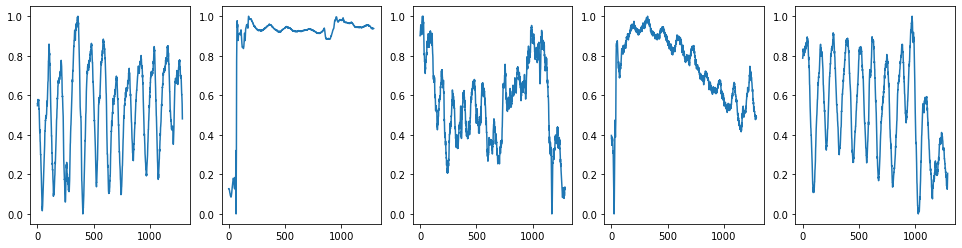

<Figure size 432x288 with 0 Axes>

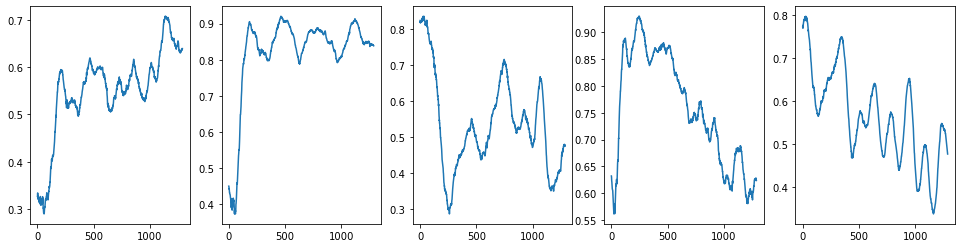

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

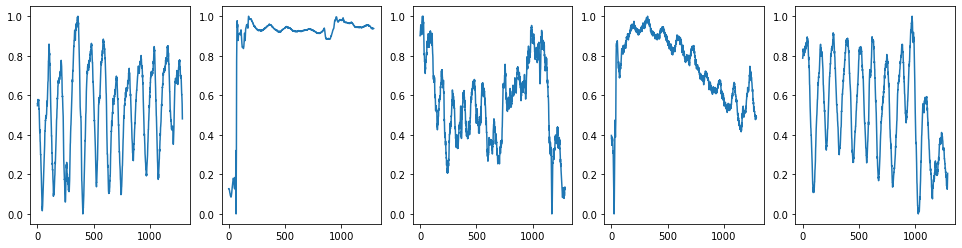

<Figure size 432x288 with 0 Axes>

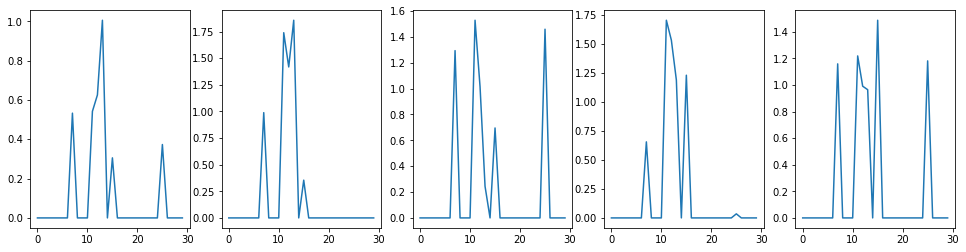

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [23]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale valid and test with train's scaler
                    valid_x = sscaler.transform(valid_x)
                    test_x = sscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [24]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [25]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [26]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_ae_enc
    if (data_name == 'phase'):
        params = params_dense_phase
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [27]:
accs = helper_loop(dense_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.004986
iteration: 2 of 23 ; time elapsed: 0:00:06.586080
iteration: 3 of 23 ; time elapsed: 0:00:12.869529
iteration: 4 of 23 ; time elapsed: 0:00:19.292979
iteration: 5 of 23 ; time elapsed: 0:00:26.160377
iteration: 6 of 23 ; time elapsed: 0:00:33.206688
iteration: 7 of 23 ; time elapsed: 0:00:40.440939
iteration: 8 of 23 ; time elapsed: 0:00:47.985850
iteration: 9 of 23 ; time elapsed: 0:00:55.816389
iteration: 10 of 23 ; time elapsed: 0:01:03.744778
iteration: 11 of 23 ; time elapsed: 0:01:12.643475
iteration: 12 of 23 ; time elapsed: 0:01:21.125948
iteration: 13 of 23 ; time elapsed: 0:01:30.374479
iteration: 14 of 23 ; time elapsed: 0:01:39.843690
iteration: 15 of 23 ; time elapsed: 0:01:49.469643
iteration: 16 of 23 ; time elapsed: 0:01:58.520543
iteration: 17 of 23 ; time elapsed: 0:02:08.124888
iteration: 18 of 23 ; time elapsed: 0:02:18.035468
iteration: 19 of 23 ; time elapsed: 0:02:27.603909
iteration: 20 of 23 ; time elapsed: 0:02

In [28]:
accuracies['simple_dense'] = accs

In [29]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.500000,62i9y
1,0.777778,0.722222,2gu87
2,0.850000,0.900000,iz2ps
3,0.583333,0.416667,1mpau
4,0.666667,0.416667,7dwjy
5,0.714286,0.785714,7swyk
6,0.750000,0.500000,94mnx
7,0.750000,0.500000,bd47a
8,0.636364,0.500000,c24ur
9,0.500000,0.625000,ctsax


In [30]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.375000     0.312500
max     0.875000     0.900000
mean    0.649169     0.578769
median  0.666667     0.533333


#### LSTM-based classifier  
based on the original author's code

In [31]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [32]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [33]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_ae_enc
    if (data_name == 'phase'):
        params = params_lstm_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.004580
iteration: 2 of 23 ; time elapsed: 0:00:41.016122
iteration: 3 of 23 ; time elapsed: 0:01:20.174277
iteration: 4 of 23 ; time elapsed: 0:02:00.478007
iteration: 5 of 23 ; time elapsed: 0:02:42.777027
iteration: 6 of 23 ; time elapsed: 0:03:26.520141
iteration: 7 of 23 ; time elapsed: 0:04:10.186895
iteration: 8 of 23 ; time elapsed: 0:04:54.057945
iteration: 9 of 23 ; time elapsed: 0:05:37.622967
iteration: 10 of 23 ; time elapsed: 0:06:22.061547
iteration: 11 of 23 ; time elapsed: 0:07:08.500452
iteration: 12 of 23 ; time elapsed: 0:07:54.325844
iteration: 13 of 23 ; time elapsed: 0:08:41.221795
iteration: 14 of 23 ; time elapsed: 0:09:28.673807
iteration: 15 of 23 ; time elapsed: 0:10:16.914534
iteration: 16 of 23 ; time elapsed: 0:11:05.350840
iteration: 17 of 23 ; time elapsed: 0:11:56.214219
iteration: 18 of 23 ; time elapsed: 0:12:53.273975
iteration: 19 of 23 ; time elapsed: 0:13:50.285843
iteration: 20 of 23 ; time elapsed: 0:14

In [35]:
accuracies['LSTM'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.500000,62i9y
1,0.833333,0.555556,2gu87
2,0.850000,0.500000,iz2ps
3,0.666667,0.458333,1mpau
4,0.750000,0.666667,7dwjy
5,1.000000,0.571429,7swyk
6,0.750000,0.666667,94mnx
7,0.875000,0.750000,bd47a
8,0.727273,0.500000,c24ur
9,0.750000,0.625000,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.500000     0.437500
max     1.000000     0.750000
mean    0.710875     0.565067
median  0.722222     0.555556


#### kNN

In [38]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [39]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [41]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_ae_enc
    if (data_name == 'phase'):
        params = params_knn_phase
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [42]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.007899
iteration: 2 of 23 ; time elapsed: 0:00:00.058007
iteration: 3 of 23 ; time elapsed: 0:00:00.094938
iteration: 4 of 23 ; time elapsed: 0:00:00.130812
iteration: 5 of 23 ; time elapsed: 0:00:00.166746
iteration: 6 of 23 ; time elapsed: 0:00:00.201653
iteration: 7 of 23 ; time elapsed: 0:00:00.241544
iteration: 8 of 23 ; time elapsed: 0:00:00.276451
iteration: 9 of 23 ; time elapsed: 0:00:00.311330
iteration: 10 of 23 ; time elapsed: 0:00:00.346236
iteration: 11 of 23 ; time elapsed: 0:00:00.383137
iteration: 12 of 23 ; time elapsed: 0:00:00.418073
iteration: 13 of 23 ; time elapsed: 0:00:00.452951
iteration: 14 of 23 ; time elapsed: 0:00:00.501819
iteration: 15 of 23 ; time elapsed: 0:00:00.554678
iteration: 16 of 23 ; time elapsed: 0:00:00.597563
iteration: 17 of 23 ; time elapsed: 0:00:00.638506
iteration: 18 of 23 ; time elapsed: 0:00:00.675384
iteration: 19 of 23 ; time elapsed: 0:00:00.711288
iteration: 20 of 23 ; time elapsed: 0:00

In [43]:
accuracies['kNN'] = accs

In [44]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,1.000000,62i9y
1,0.833333,0.555556,2gu87
2,0.750000,0.750000,iz2ps
3,0.541667,0.500000,1mpau
4,0.583333,0.416667,7dwjy
5,0.857143,0.642857,7swyk
6,0.500000,0.416667,94mnx
7,0.500000,0.625000,bd47a
8,0.681818,0.545455,c24ur
9,0.750000,0.750000,ctsax


In [45]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.500000     0.416667
max     0.923077     1.000000
mean    0.673168     0.583396
median  0.681818     0.545455


####  SVC

In [46]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [47]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [48]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [49]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_ae_enc
    if (data_name == 'phase'):
        params = params_svc_phase
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [50]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.005957
iteration: 2 of 23 ; time elapsed: 0:00:00.758021
iteration: 3 of 23 ; time elapsed: 0:00:01.445751
iteration: 4 of 23 ; time elapsed: 0:00:02.090598
iteration: 5 of 23 ; time elapsed: 0:00:02.793172
iteration: 6 of 23 ; time elapsed: 0:00:03.528206
iteration: 7 of 23 ; time elapsed: 0:00:04.255961
iteration: 8 of 23 ; time elapsed: 0:00:04.995234
iteration: 9 of 23 ; time elapsed: 0:00:05.676027
iteration: 10 of 23 ; time elapsed: 0:00:06.378275
iteration: 11 of 23 ; time elapsed: 0:00:07.085420
iteration: 12 of 23 ; time elapsed: 0:00:07.771545
iteration: 13 of 23 ; time elapsed: 0:00:08.462700
iteration: 14 of 23 ; time elapsed: 0:00:09.152799
iteration: 15 of 23 ; time elapsed: 0:00:09.839514
iteration: 16 of 23 ; time elapsed: 0:00:10.486715
iteration: 17 of 23 ; time elapsed: 0:00:11.198450
iteration: 18 of 23 ; time elapsed: 0:00:11.942422
iteration: 19 of 23 ; time elapsed: 0:00:12.647223
iteration: 20 of 23 ; time elapsed: 0:00

In [51]:
accuracies['SVC'] = accs

In [52]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.500000,62i9y
1,0.888889,0.611111,2gu87
2,0.700000,0.750000,iz2ps
3,0.583333,0.458333,1mpau
4,0.583333,0.500000,7dwjy
5,0.785714,0.500000,7swyk
6,0.833333,0.666667,94mnx
7,0.875000,0.875000,bd47a
8,0.545455,0.500000,c24ur
9,0.750000,0.625000,ctsax


In [53]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.444444     0.437500
max     0.888889     0.875000
mean    0.666182     0.578224
median  0.625000     0.576923


#### Random Forest

In [54]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [55]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [56]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [57]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_ae_enc
    if (data_name == 'phase'):
        params = params_rf_phase
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [58]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006982
iteration: 2 of 23 ; time elapsed: 0:00:04.084992
iteration: 3 of 23 ; time elapsed: 0:00:08.005620
iteration: 4 of 23 ; time elapsed: 0:00:11.752489
iteration: 5 of 23 ; time elapsed: 0:00:15.724630
iteration: 6 of 23 ; time elapsed: 0:00:19.595104
iteration: 7 of 23 ; time elapsed: 0:00:23.460083
iteration: 8 of 23 ; time elapsed: 0:00:27.475459
iteration: 9 of 23 ; time elapsed: 0:00:31.335048
iteration: 10 of 23 ; time elapsed: 0:00:35.240955
iteration: 11 of 23 ; time elapsed: 0:00:39.195721
iteration: 12 of 23 ; time elapsed: 0:00:43.098735
iteration: 13 of 23 ; time elapsed: 0:00:46.973020
iteration: 14 of 23 ; time elapsed: 0:00:50.765953
iteration: 15 of 23 ; time elapsed: 0:00:54.637561
iteration: 16 of 23 ; time elapsed: 0:00:58.550752
iteration: 17 of 23 ; time elapsed: 0:01:02.400269
iteration: 18 of 23 ; time elapsed: 0:01:06.446511
iteration: 19 of 23 ; time elapsed: 0:01:10.392289
iteration: 20 of 23 ; time elapsed: 0:01

In [59]:
accuracies['random_forest'] = accs

In [60]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,1.000000,1.000000,62i9y
1,0.777778,0.722222,2gu87
2,0.850000,0.800000,iz2ps
3,0.666667,0.416667,1mpau
4,0.500000,0.500000,7dwjy
5,0.714286,0.642857,7swyk
6,0.666667,0.750000,94mnx
7,0.625000,0.625000,bd47a
8,0.590909,0.454545,c24ur
9,0.750000,0.500000,ctsax


In [61]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.437500     0.375000
max     1.000000     1.000000
mean    0.676931     0.602247
median  0.666667     0.583333


#### Naive Bayesian

In [62]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [63]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [64]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.006767
iteration: 2 of 23 ; time elapsed: 0:00:00.045694
iteration: 3 of 23 ; time elapsed: 0:00:00.083595
iteration: 4 of 23 ; time elapsed: 0:00:00.122488
iteration: 5 of 23 ; time elapsed: 0:00:00.160954
iteration: 6 of 23 ; time elapsed: 0:00:00.197829
iteration: 7 of 23 ; time elapsed: 0:00:00.236751
iteration: 8 of 23 ; time elapsed: 0:00:00.273685
iteration: 9 of 23 ; time elapsed: 0:00:00.310586
iteration: 10 of 23 ; time elapsed: 0:00:00.351510
iteration: 11 of 23 ; time elapsed: 0:00:00.393399
iteration: 12 of 23 ; time elapsed: 0:00:00.432293
iteration: 13 of 23 ; time elapsed: 0:00:00.472186
iteration: 14 of 23 ; time elapsed: 0:00:00.509088
iteration: 15 of 23 ; time elapsed: 0:00:00.546454
iteration: 16 of 23 ; time elapsed: 0:00:00.586315
iteration: 17 of 23 ; time elapsed: 0:00:00.624214
iteration: 18 of 23 ; time elapsed: 0:00:00.661380
iteration: 19 of 23 ; time elapsed: 0:00:00.700248
iteration: 20 of 23 ; time elapsed: 0:00

In [65]:
accuracies['naive_bayesian'] = accs

In [66]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.500000,62i9y
1,0.277778,0.388889,2gu87
2,0.350000,0.400000,iz2ps
3,0.500000,0.500000,1mpau
4,0.666667,0.666667,7dwjy
5,0.571429,0.571429,7swyk
6,0.583333,0.416667,94mnx
7,0.750000,0.375000,bd47a
8,0.500000,0.500000,c24ur
9,0.625000,0.625000,ctsax


In [67]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.277778     0.375000
max     0.750000     0.750000
mean    0.564101     0.517296
median  0.562500     0.500000


#### XGBoost

In [68]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [69]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [70]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [71]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_ae_enc
    if (data_name == 'phase'):
        params = params_xgb_phase
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [72]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006979
iteration: 2 of 23 ; time elapsed: 0:00:03.901799
iteration: 3 of 23 ; time elapsed: 0:00:06.682053
iteration: 4 of 23 ; time elapsed: 0:00:09.414692
iteration: 5 of 23 ; time elapsed: 0:00:12.198178
iteration: 6 of 23 ; time elapsed: 0:00:15.266409
iteration: 7 of 23 ; time elapsed: 0:00:18.243753
iteration: 8 of 23 ; time elapsed: 0:00:21.305326
iteration: 9 of 23 ; time elapsed: 0:00:24.208422
iteration: 10 of 23 ; time elapsed: 0:00:27.134969
iteration: 11 of 23 ; time elapsed: 0:00:30.169903
iteration: 12 of 23 ; time elapsed: 0:00:33.028958
iteration: 13 of 23 ; time elapsed: 0:00:35.875948
iteration: 14 of 23 ; time elapsed: 0:00:38.839730
iteration: 15 of 23 ; time elapsed: 0:00:41.686005
iteration: 16 of 23 ; time elapsed: 0:00:44.654718
iteration: 17 of 23 ; time elapsed: 0:00:47.639404
iteration: 18 of 23 ; time elapsed: 0:00:50.720434
iteration: 19 of 23 ; time elapsed: 0:00:53.814071
iteration: 20 of 23 ; time elapsed: 0:00

In [73]:
accuracies['XGBoost'] = accs

In [74]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,1.000000,62i9y
1,0.555556,0.555556,2gu87
2,0.850000,0.800000,iz2ps
3,0.750000,0.500000,1mpau
4,0.416667,0.583333,7dwjy
5,0.500000,0.571429,7swyk
6,0.583333,0.666667,94mnx
7,0.625000,0.625000,bd47a
8,0.590909,0.636364,c24ur
9,0.750000,0.625000,ctsax


In [75]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.375000     0.375000
max     0.850000     1.000000
mean    0.609935     0.606303
median  0.590909     0.583333


###  Compare Accuracies

Save all accuracies to results csv file:

In [76]:
results_path = "results/BvR/BvR-all-tfv1.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [77]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.375000     0.312500
max     0.875000     0.900000
mean    0.649169     0.578769
median  0.666667     0.533333


----------- LSTM: -----------
           phase  contractive
min     0.500000     0.437500
max     1.000000     0.750000
mean    0.710875     0.565067
median  0.722222     0.555556


----------- kNN: -----------
           phase  contractive
min     0.500000     0.416667
max     0.923077     1.000000
mean    0.673168     0.583396
median  0.681818     0.545455


----------- SVC: -----------
           phase  contractive
min     0.444444     0.437500
max     0.888889     0.875000
mean    0.666182     0.578224
median  0.625000     0.576923


----------- random_forest: -----------
           phase  contractive
min     0.437500     0.375000
max     1.000000     1.000000
mean    0.676931     0.602247
median  0.666667     0.583333


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [78]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.500000     0.500000   62i9y
1   0.777778     0.722222   2gu87
2   0.850000     0.900000   iz2ps
3   0.583333     0.416667   1mpau
4   0.666667     0.416667   7dwjy
5   0.714286     0.785714   7swyk
6   0.750000     0.500000   94mnx
7   0.750000     0.500000   bd47a
8   0.636364     0.500000   c24ur
9   0.500000     0.625000   ctsax
10  0.562500     0.312500   dkhty
11  0.444444     0.444444   e4gay
12  0.687500     0.562500   ef5rq
13  0.550000     0.500000   f1gjp
14  0.875000     0.687500   hpbxa
15  0.766667     0.533333   pmyfl
16  0.833333     0.500000   r89k1
17  0.666667     0.750000   tn4vl
18  0.687500     0.500000   td5pr
19  0.600000     0.700000   gyqu9
20  0.653846     0.538462   fzchw
21  0.500000     0.666667   l53hg
22  0.375000     0.750000   3n2f9


LSTM:
       phase  contractive test id
0   0.500000     0.500000   62i9y
1   0.833333     0.555556   2gu87
2   0.850000     0.500000   iz2ps
3   0.666667     0.458333 